- title: Predictive coding - part 1
- author: Amol Kelkar
- date: 2018-10-03
- category: ai
- tags: keras, lstm, rnn, online learning

In the [previous post](./pseudo-online-lstm-rnn-part-2.html), we built `PseudoOnlineModel` Keras model class. Here will build a simple online predictive coding network.

## Simplified predictive coding

Let's create a simplified predictive coding network with 2 layers.

Input to layer 0 is the input signal $\phi$

${\mu}_0 = \phi$

Input of layer 1 will be the error in layer 0

${\mu}_1 = {\epsilon}_0$

Layer 1 predicts the input to layer 0 using its input and error from layer 0

$\hat{{\mu}_0} = g_0({\mu}_1, {\epsilon}_0)$

Layer 0 error is

${\epsilon}_0 = {\mu}_0 - \hat{{\mu}_0}$


$g_0$ represents the neural network in this simplified predictive coding model. Input to $g_0$ is ${\mu}_1$, which is same as ${\epsilon}_0$. Target output for $g_0$ is ${\mu}_0$, which is same as input signal $\phi$.


## Relevant code from previous post

In [ ]:
class SlidingWindowBuffer(object):
    def __init__(self, item_count, item_shape=(1)):
        self.item_shape = item_shape
        self.item_count = item_count
        self.buffer = []
        
    def append_item(self, item):
        # return None while gathering initial items
        if len(self.buffer) < self.item_count - 1:
            self.buffer.append(item)
            return None
        
        # once enough items, convert to np.array
        elif len(self.buffer) == self.item_count - 1:
            self.buffer.append(item)
            self.buffer = np.array(self.buffer)
            
        else:
            self.buffer = np.roll(self.buffer, -1, axis=0)
            self.buffer[-1] = item
            
        return self.buffer

class OnlineToBatch(object):
    def __init__(self, t_sample, n_batch, X_t_shape=(1,), y_t_shape=(1,)):
        self.t_sample = t_sample
        self.n_batch = n_batch
        self.X_t_shape = X_t_shape
        self.y_t_shape = y_t_shape

        self.X_points_buffer = SlidingWindowBuffer(item_count = t_sample, item_shape=X_t_shape)
        self.y_points_buffer = SlidingWindowBuffer(item_count = t_sample, item_shape=y_t_shape)

        self.reset_batch_buffer()
    
    def reset_batch_buffer(self):
        self.X_batch = []
        self.y_batch = []
        
    # add point to current batch
    def add(self, X_point, y_point, epochs=1, verbose=2):
        X_sample = self.X_points_buffer.append_item(X_point)
        y_sample = self.y_points_buffer.append_item(y_point)

        if X_sample is not None:
            assert y_sample is not None
            self.X_batch.append(X_sample)
            self.y_batch.append(y_sample)

            if len(self.X_batch) == self.n_batch:
                assert len(self.y_batch) == self.n_batch
                
                X = np.array(self.X_batch)
                assert X.shape == ((self.n_batch, self.t_sample) + self.X_t_shape)
                
                y = np.array(self.y_batch)
                assert y.shape == ((self.n_batch, self.t_sample) + self.y_t_shape)

                self.reset_batch_buffer()
                return X, y
        return None, None
    
    

In [ ]:
import keras
from keras import models

class PseudoOnlineModel(models.Model):
    def __init__(self, n_batch, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.n_batch = n_batch
        assert type(self.n_batch) == int
        
        assert len(self.inputs) == 1, "For now, only support models with a single input layer."
        input_shape = keras.backend.int_shape(self.inputs[0])
        assert input_shape[0] is None or self.n_batch == input_shape[0], "Input batch size must match if specified"
        self.t_sample = input_shape[1]
        assert type(self.t_sample) == int, "Sample length must be specified"
        self.X_t_shape = input_shape[2:]
        
        assert len(self.outputs) == 1, "For now, only support models with a single output layer."
        output_shape = keras.backend.int_shape(self.outputs[0])
        assert output_shape[0] is None or self.n_batch == output_shape[0], "Output batch size must match if specified"
        assert self.t_sample == output_shape[1], "input and output layer should use the same sample size"
        y_t_shape = output_shape[2:]
        
        self.online_to_batch = OnlineToBatch(t_sample = self.t_sample, n_batch = self.n_batch)
        
    def fit(self, training_X_point, training_y_point, *args, **kwargs):
        (X, y) = self.online_to_batch.add(training_X_point, training_y_point)
        if X is not None:
            assert y is not None
            print('calling fit() with X {0} and y {1}'.format(X.shape, y.shape))
            results = super().fit(X, y, batch_size=self.n_batch, *args, **kwargs)
            return (results, X, y)
        else:
            return (None, None, None)


## Generate sample time series data

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras
import sys, time
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))

def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)
    
set_seed(122)

def random_sample(len_ts=3000):
    c_range = range(5,10)
    c1 = np.random.choice(c_range)
    u = np.random.random(1)
    const = -1.0/len_ts
    ts = np.arange(0,len_ts)
    
    x1 = np.cos(ts/float(1.0 + c1))
    x1 = x1*ts*u*const
    X = np.array([x1]).T
    return X

def plot_samples(samples):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1,1,1)
    ax.set_ylim(-0.5,0.5)
    
    sample0 = samples[0]
    ax.plot(sample0['data'][:,0],"--",label=sample0['name'])

    sample1 = samples[1]
    ax.plot(sample1['data'][:,0],label=sample1['name'],linewidth=3,alpha = 0.5)

    if len(samples) > 2:
        sample2 = samples[2]
        ax.plot(sample2['data'][:,0],label=sample2['name'],linewidth=2,alpha = 0.5)

    plt.legend()
    plt.show()
    
# plot_samples([
#     {'data': random_sample(), 'name': 'X'},
#     {'data': random_sample(), 'name': 'y'},
#     {'data': random_sample(), 'name': 'ypred'},
# ])

In [ ]:
class SampleDataPointsGenerator(object):
    def __init__(self, ts=3000):
        self.sample_data = None
        self.ts = ts
        self.index = 0
        
    def __next__(self):
        if self.sample_data is None or self.index == self.ts:
            self.sample_data = random_sample(len_ts = self.ts)
            self.index = 0
            
        retval = self.sample_data[self.index]
        self.index += 1
        return retval

## Training

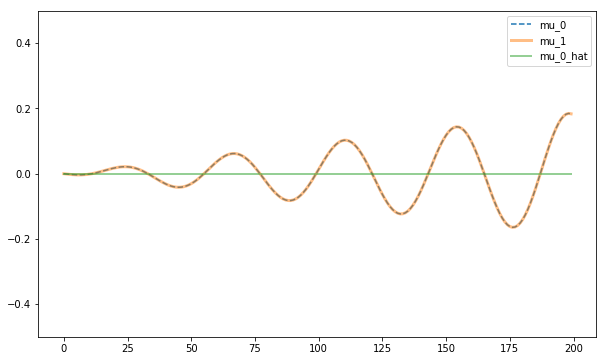

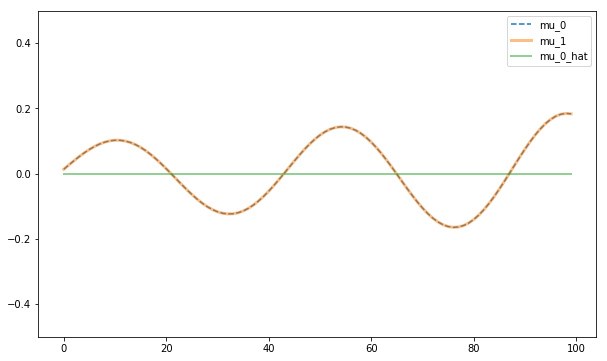

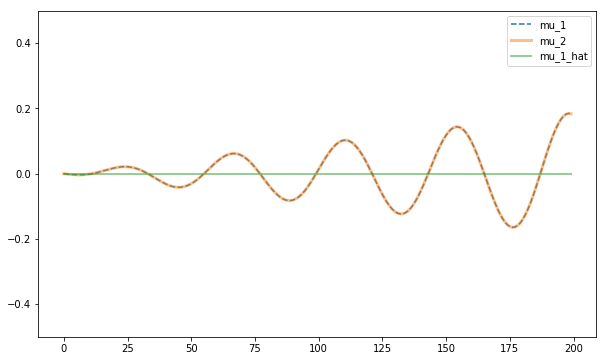

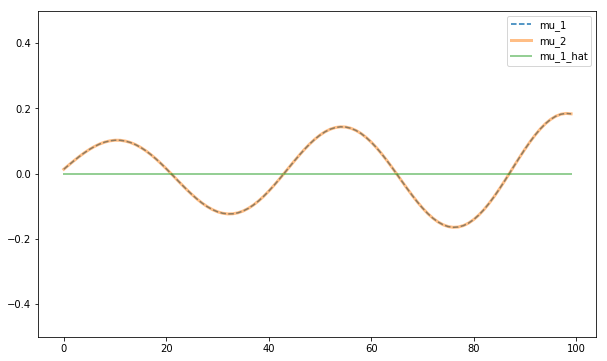

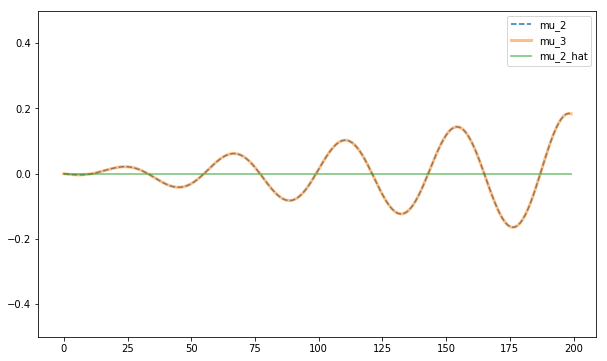

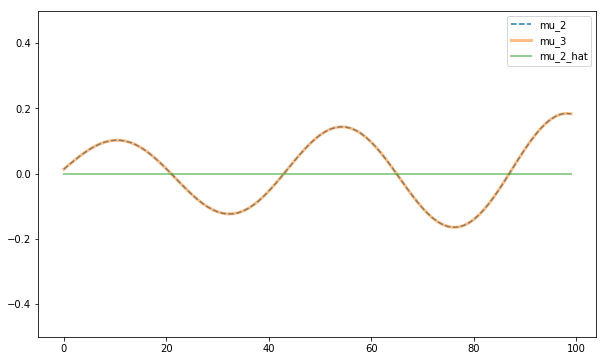

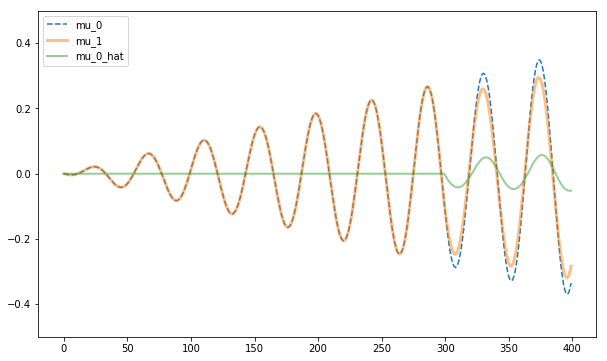

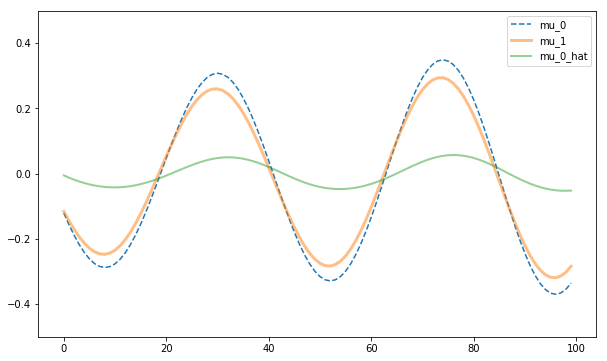

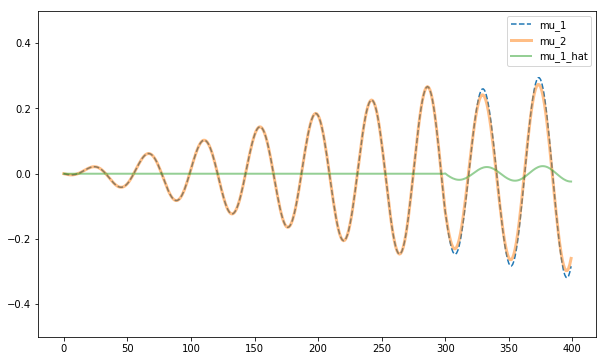

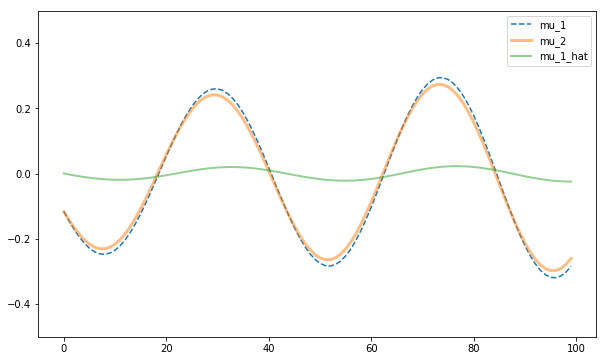

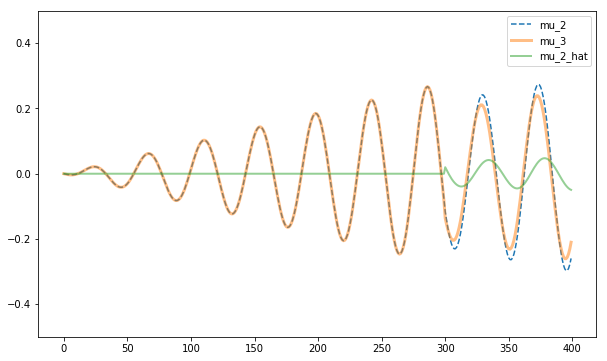

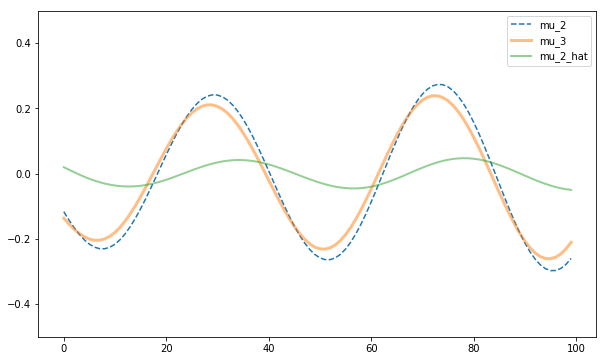

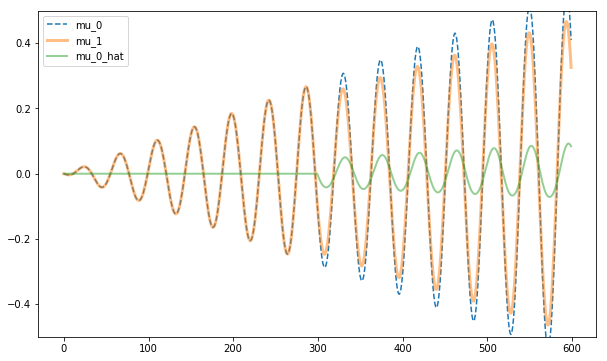

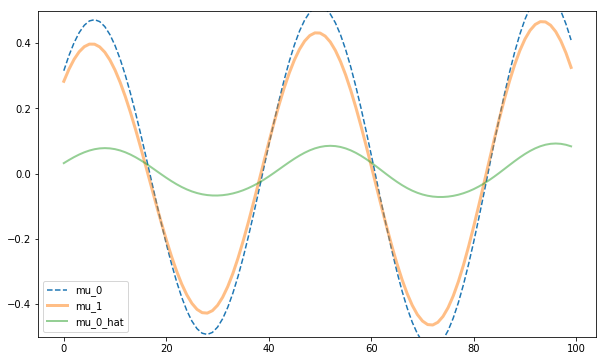

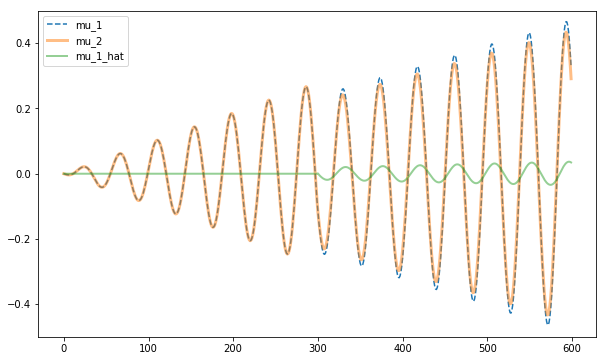

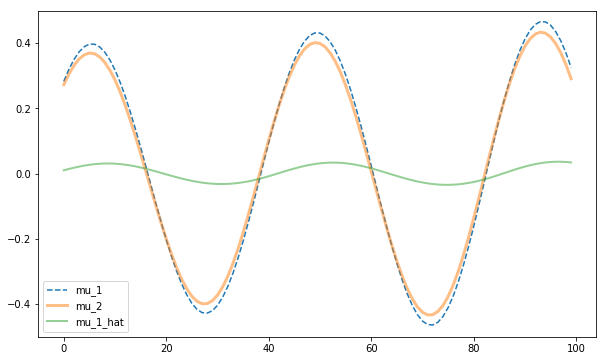

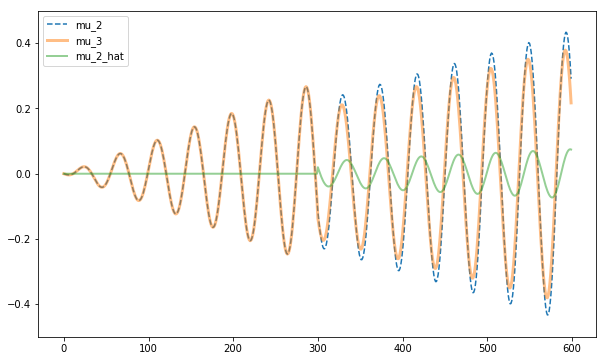

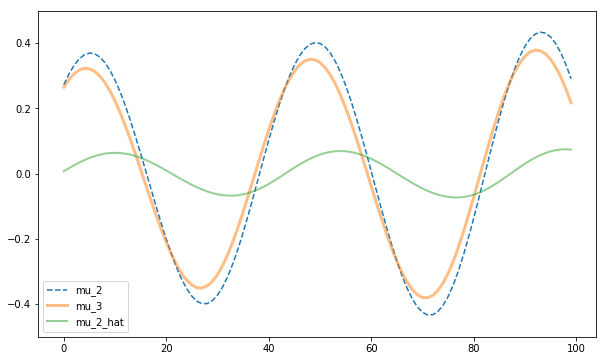

calling fit() with X (500, 300, 1) and y (500, 300, 1)
calling fit() with X (500, 300, 1) and y (500, 300, 1)
calling fit() with X (500, 300, 1) and y (500, 300, 1)


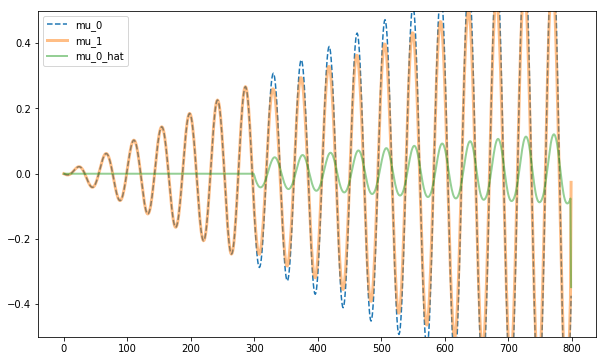

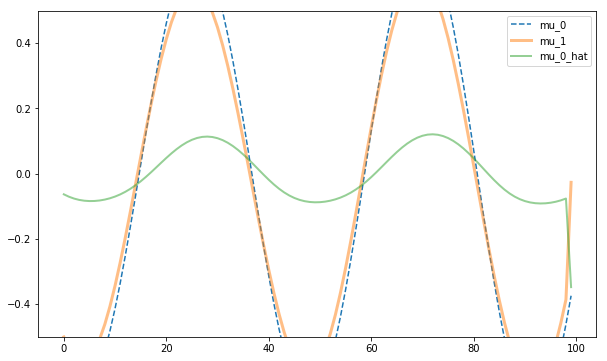

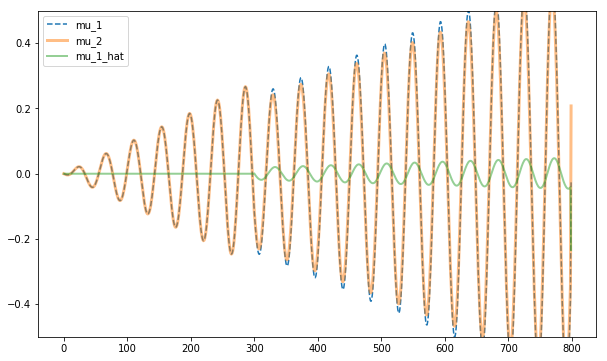

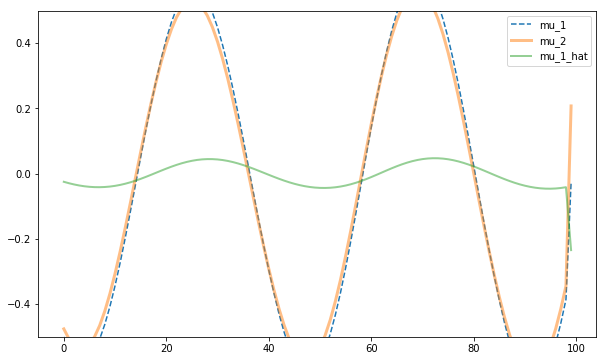

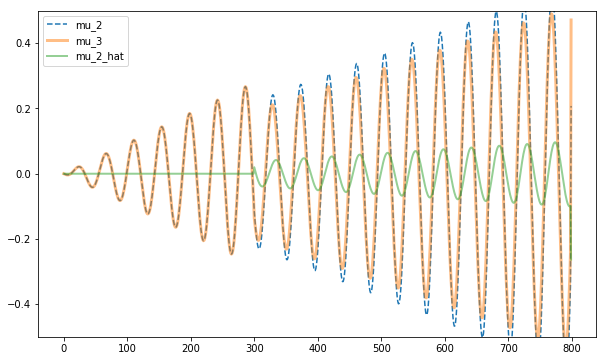

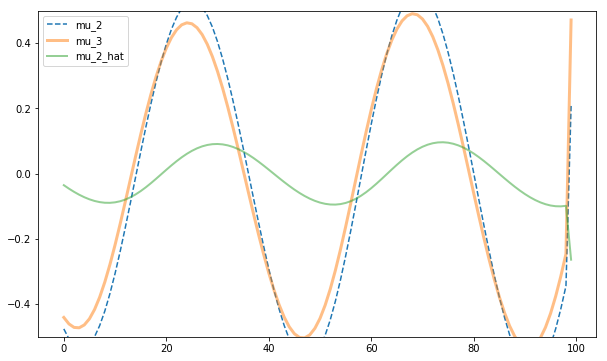

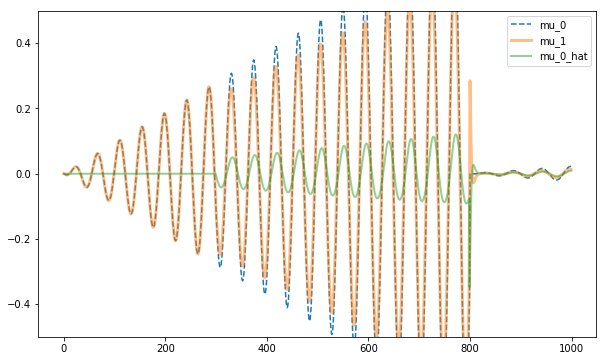

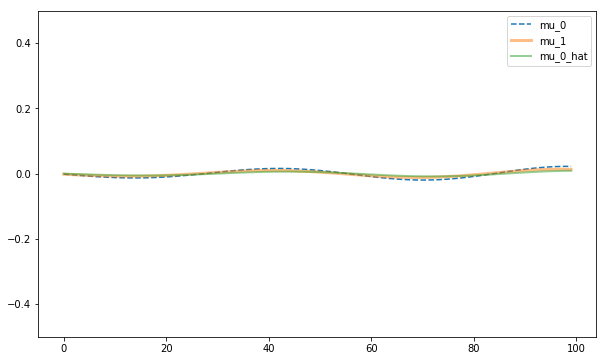

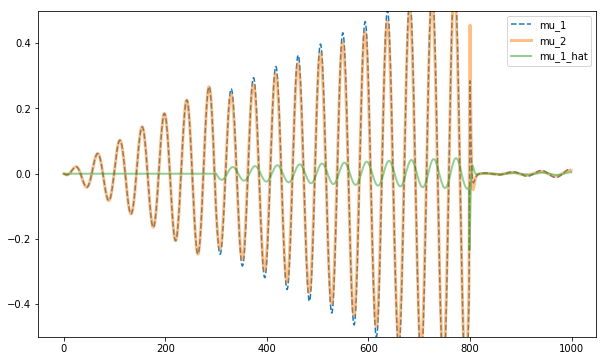

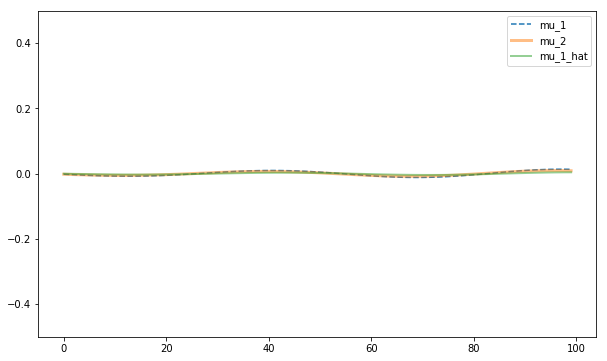

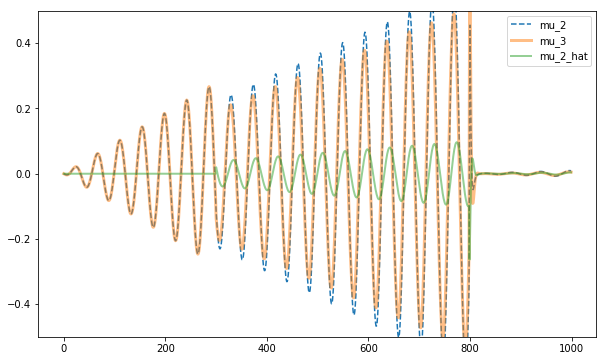

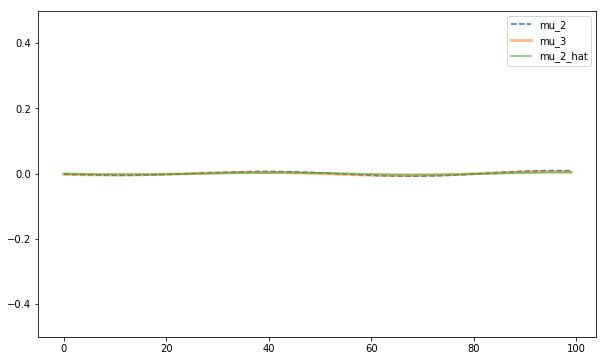

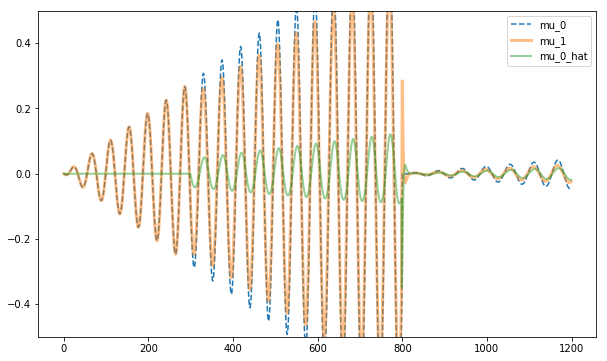

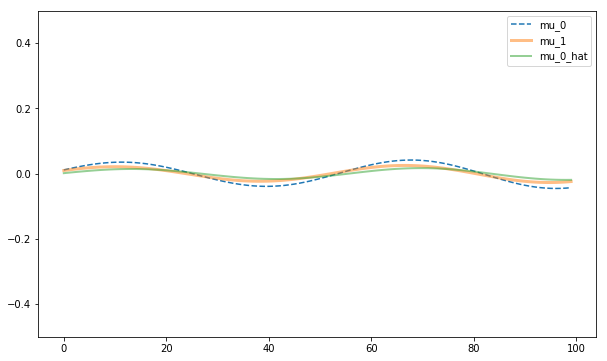

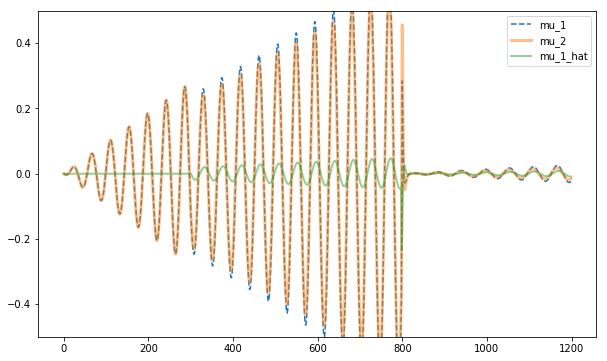

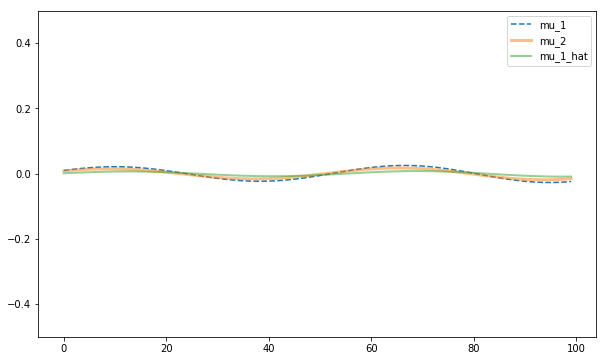

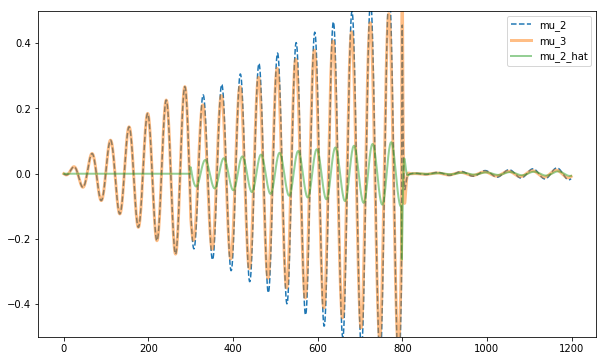

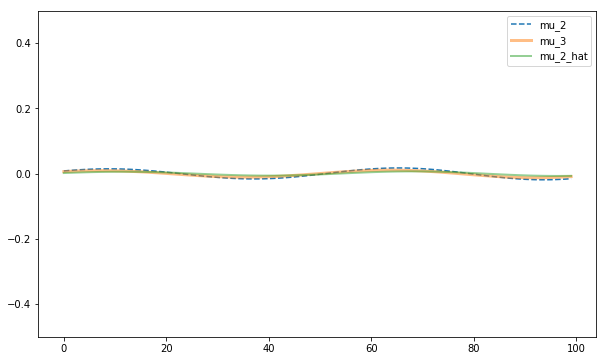

calling fit() with X (500, 300, 1) and y (500, 300, 1)
calling fit() with X (500, 300, 1) and y (500, 300, 1)
calling fit() with X (500, 300, 1) and y (500, 300, 1)


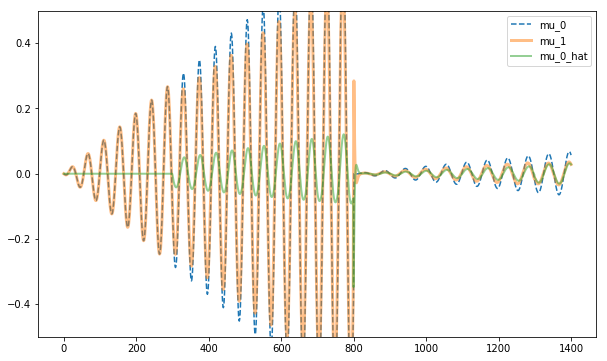

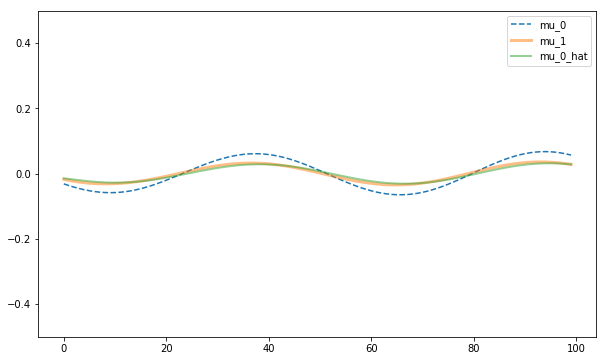

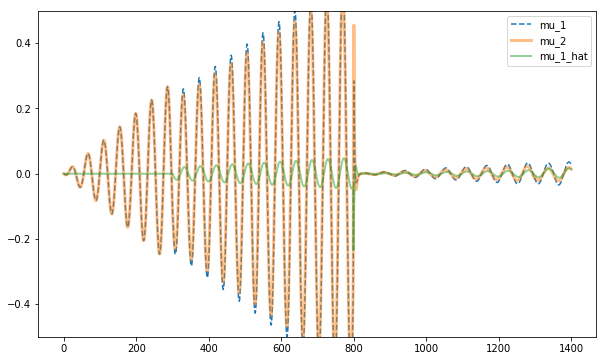

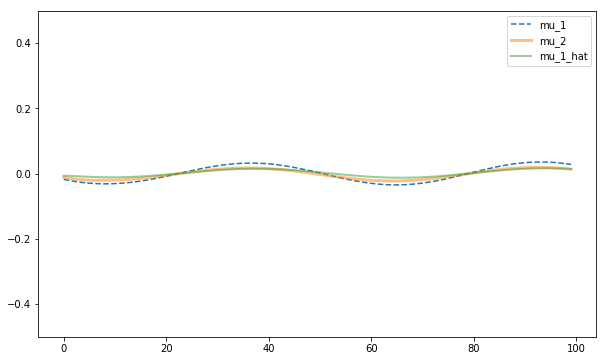

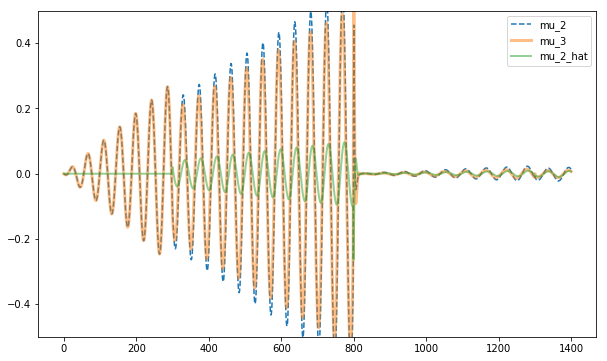

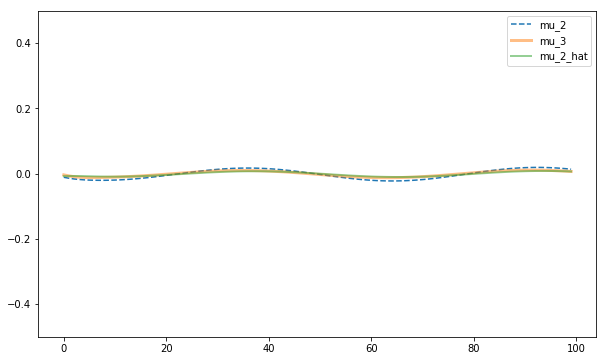

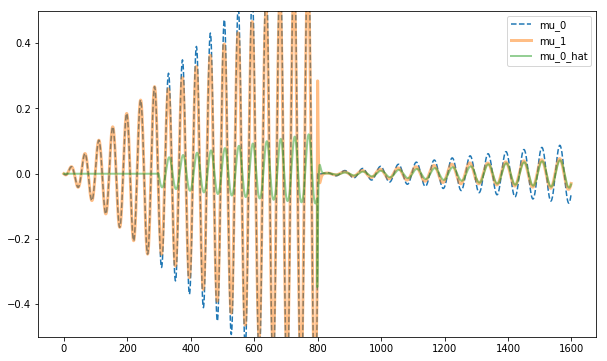

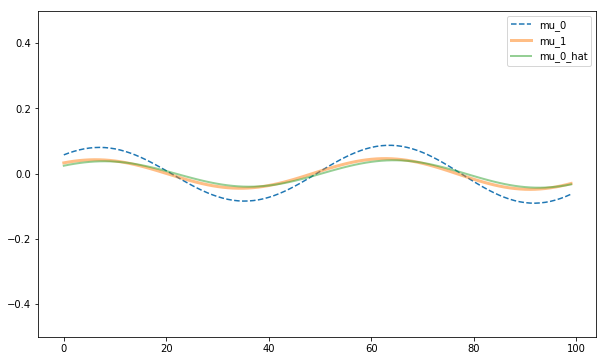

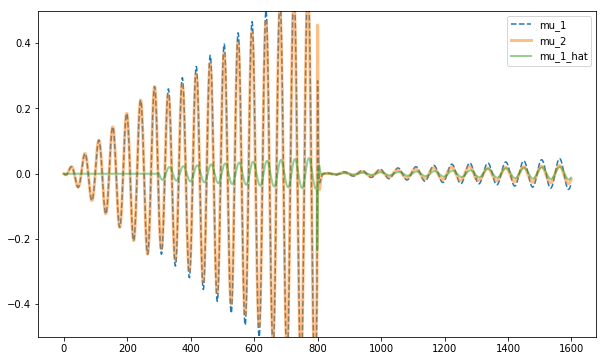

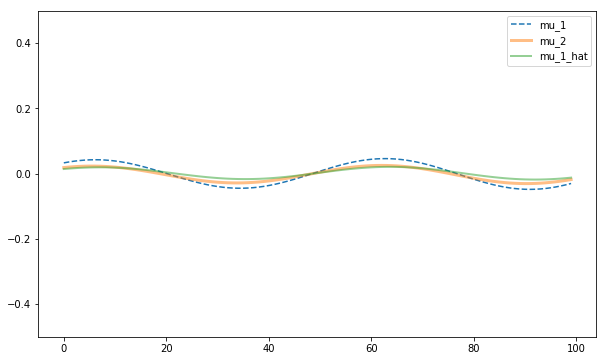

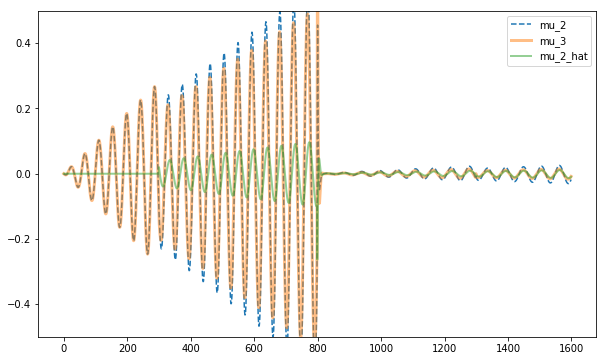

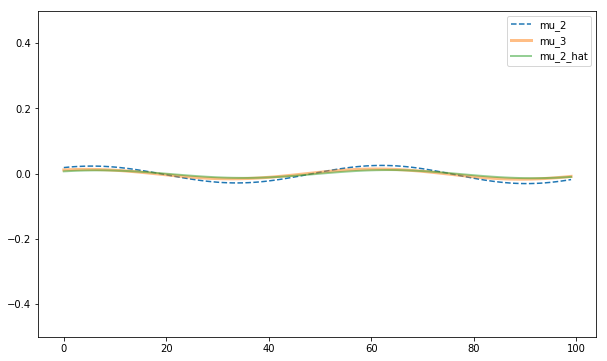

calling fit() with X (500, 300, 1) and y (500, 300, 1)
calling fit() with X (500, 300, 1) and y (500, 300, 1)
calling fit() with X (500, 300, 1) and y (500, 300, 1)


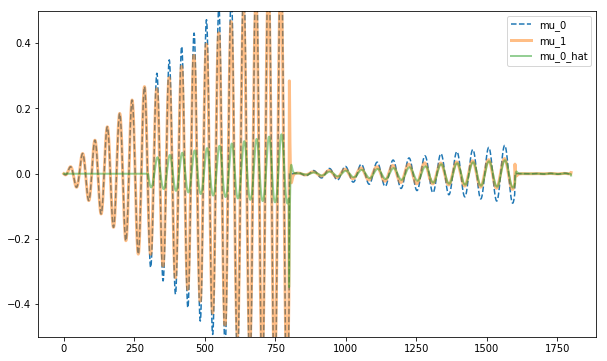

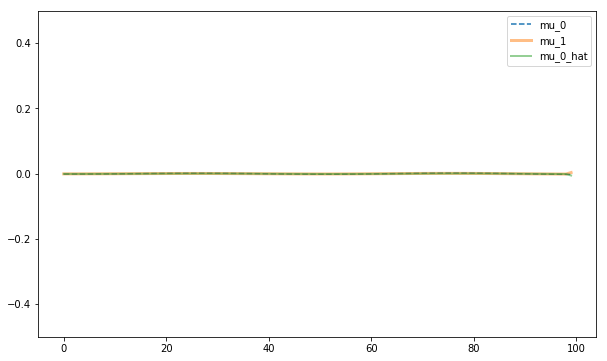

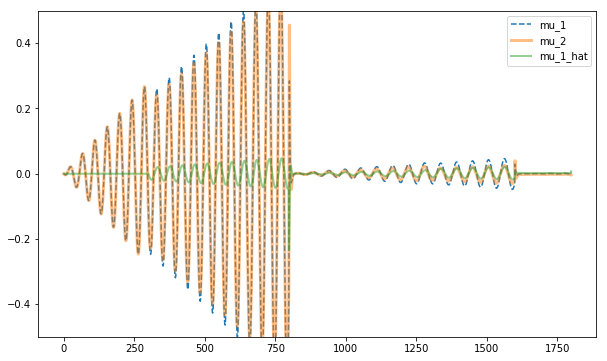

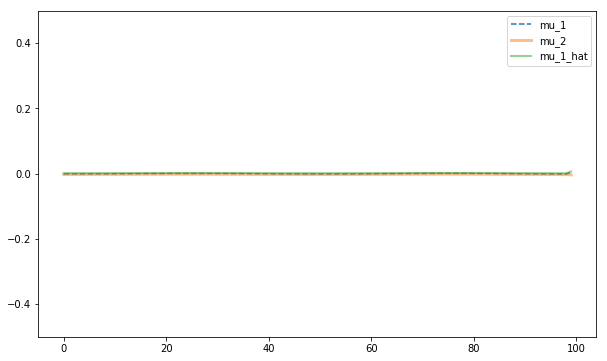

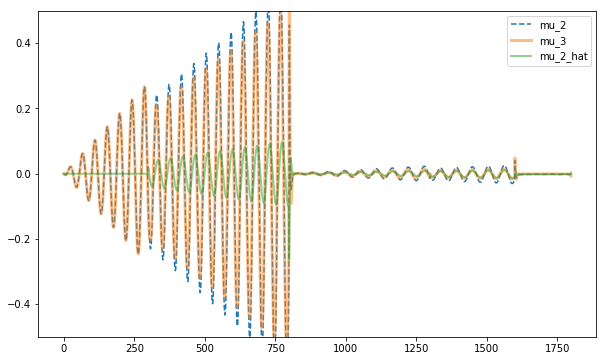

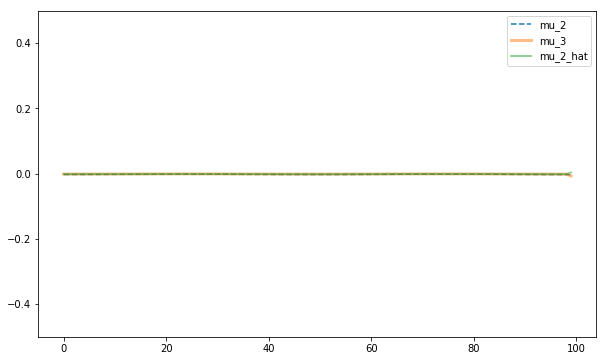

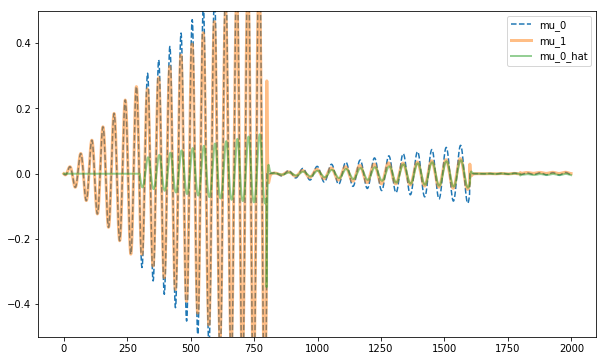

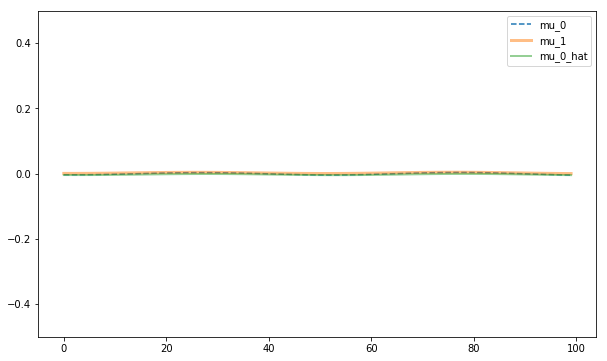

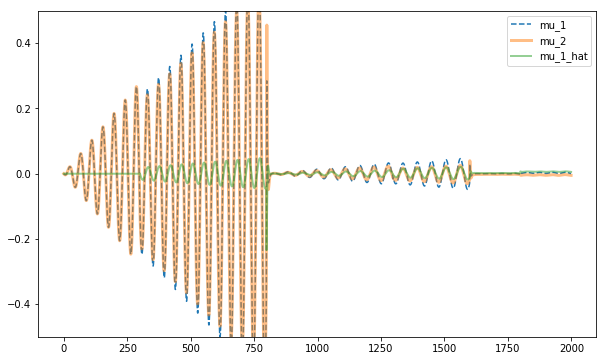

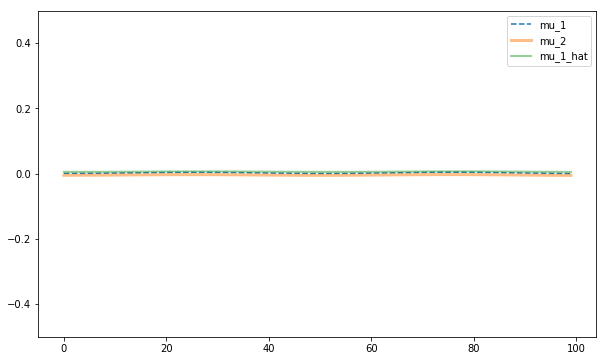

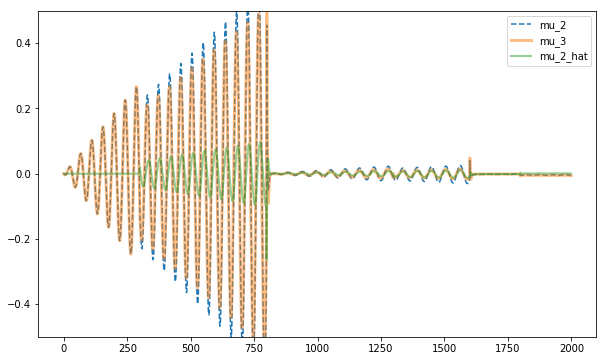

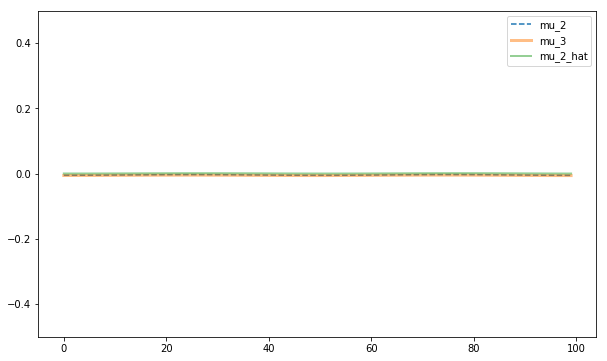

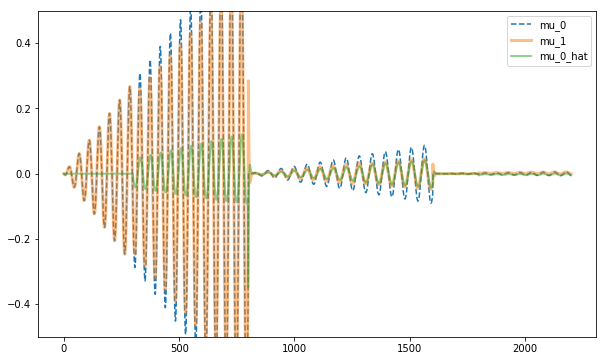

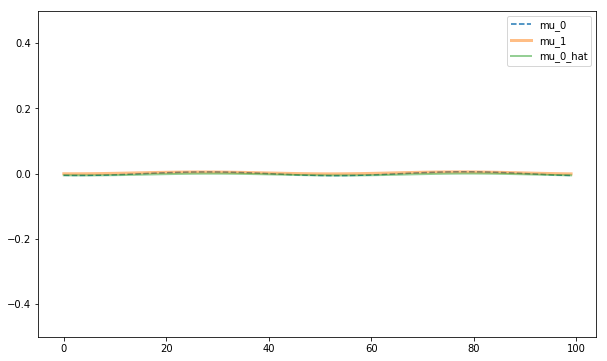

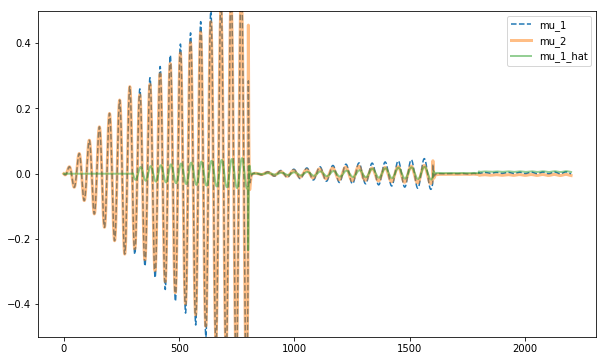

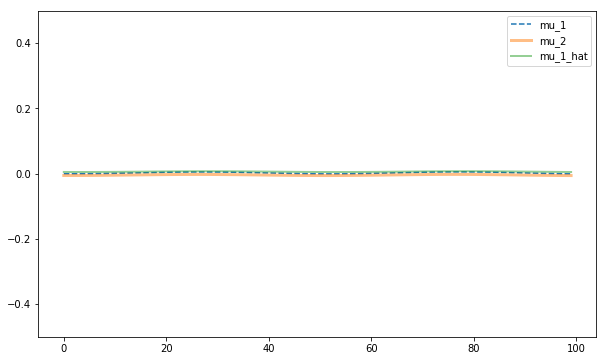

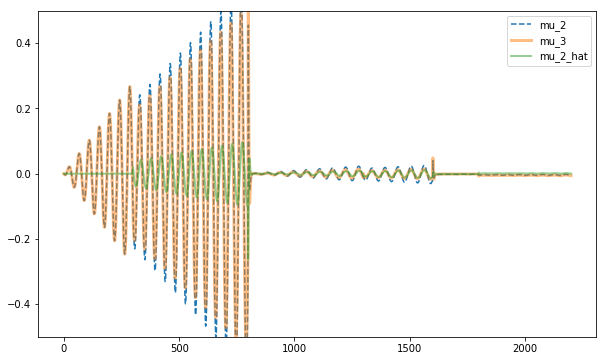

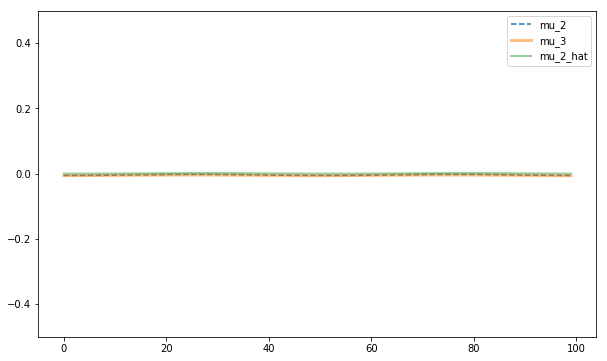

calling fit() with X (500, 300, 1) and y (500, 300, 1)
calling fit() with X (500, 300, 1) and y (500, 300, 1)
calling fit() with X (500, 300, 1) and y (500, 300, 1)


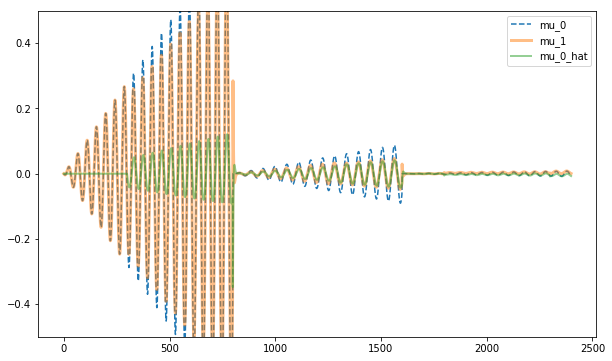

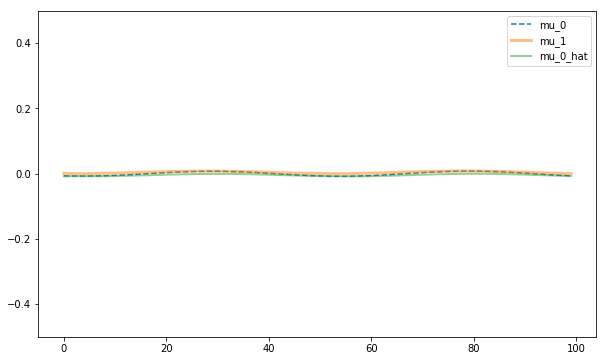

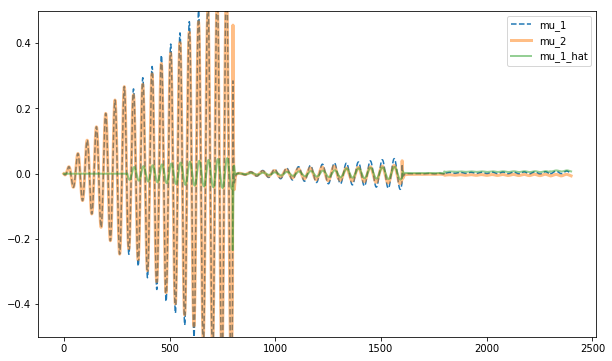

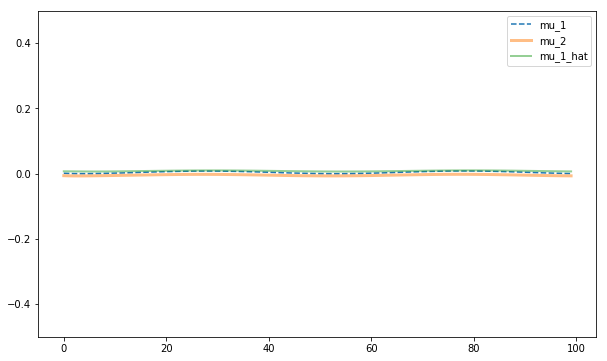

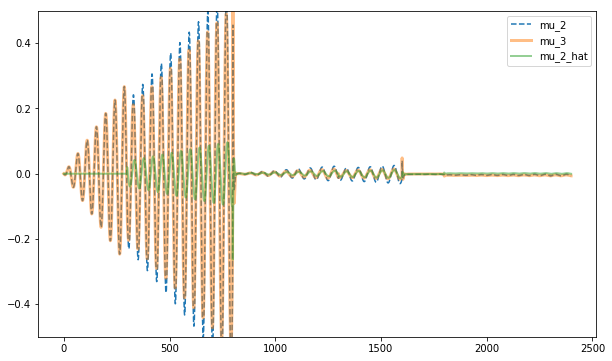

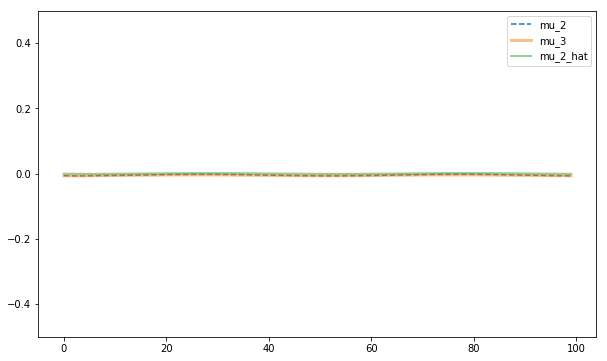

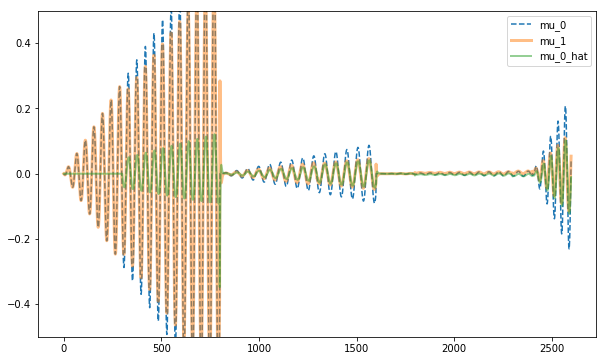

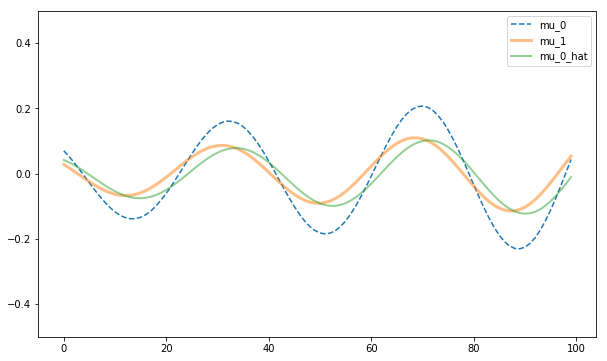

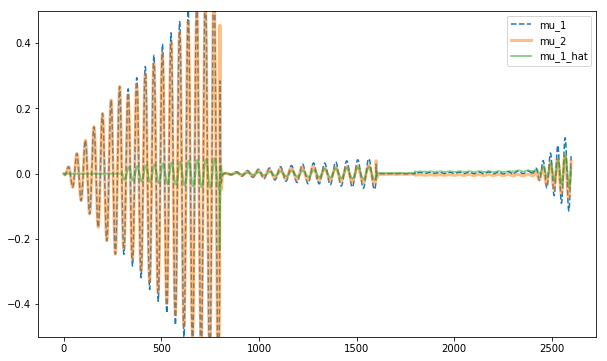

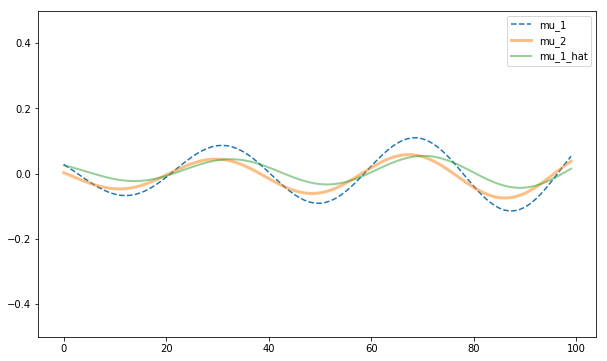

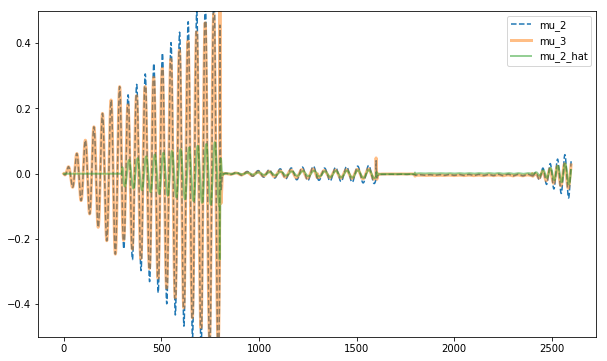

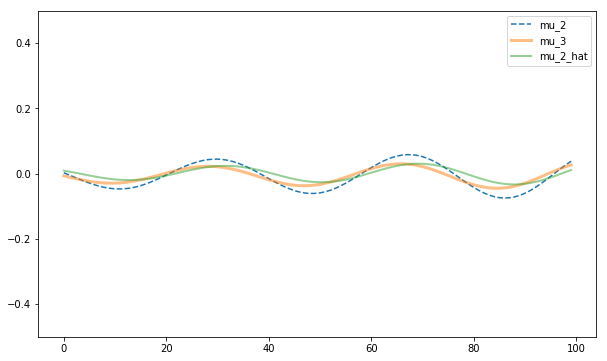

calling fit() with X (500, 300, 1) and y (500, 300, 1)
calling fit() with X (500, 300, 1) and y (500, 300, 1)
calling fit() with X (500, 300, 1) and y (500, 300, 1)


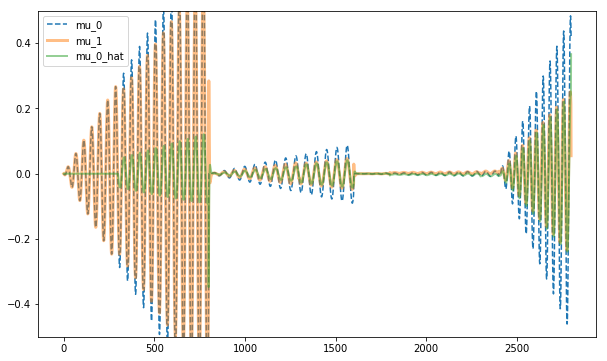

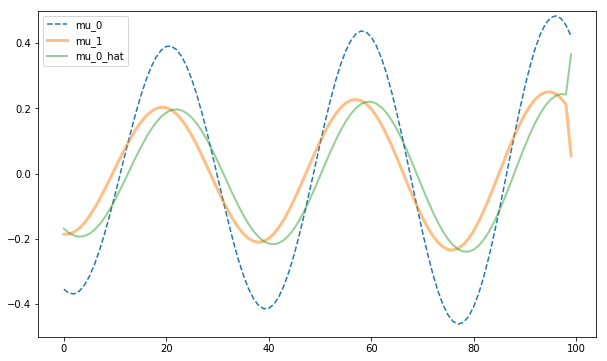

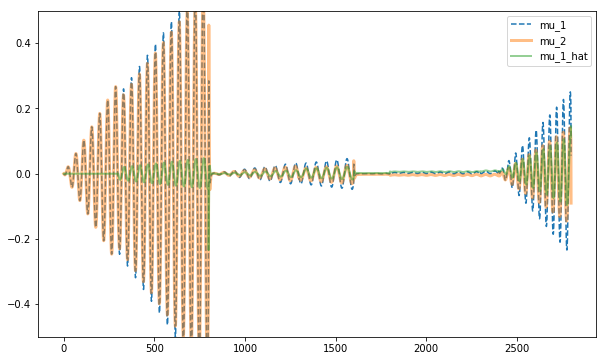

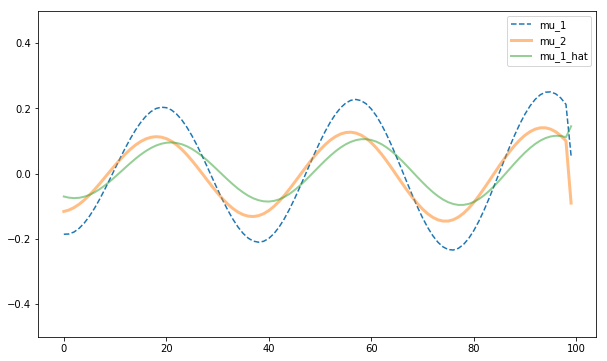

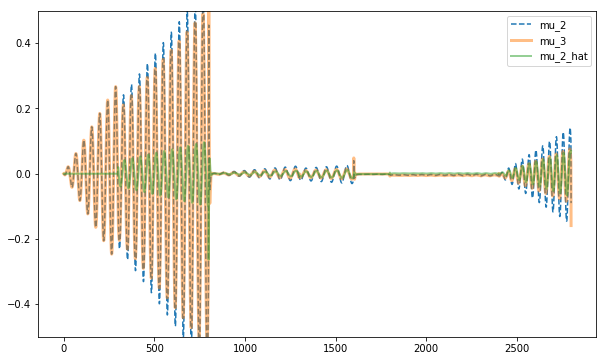

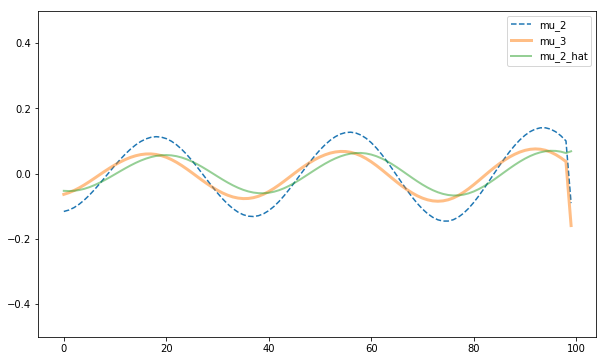

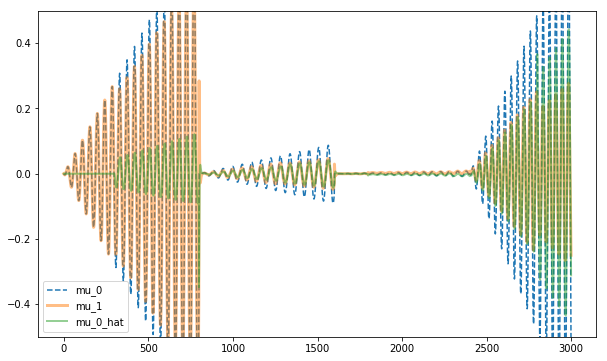

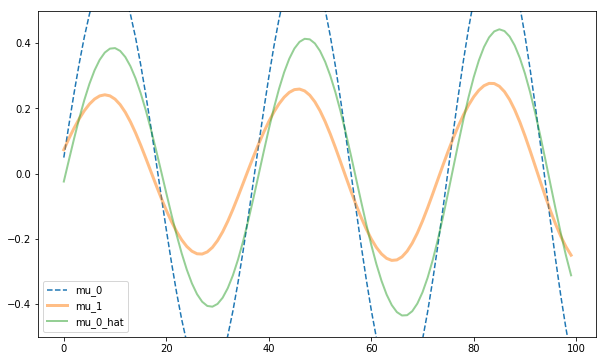

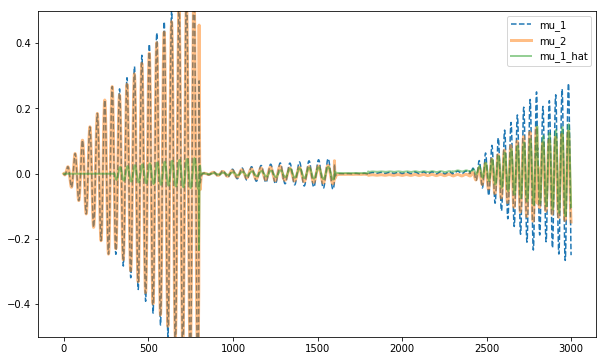

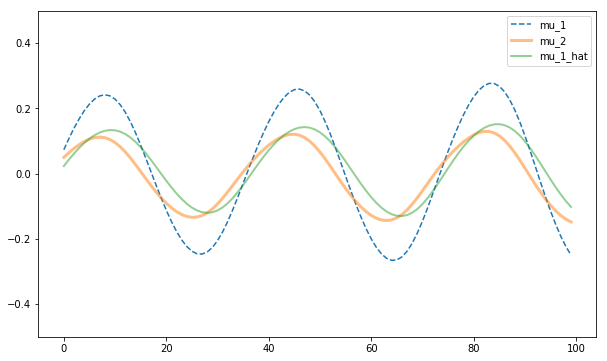

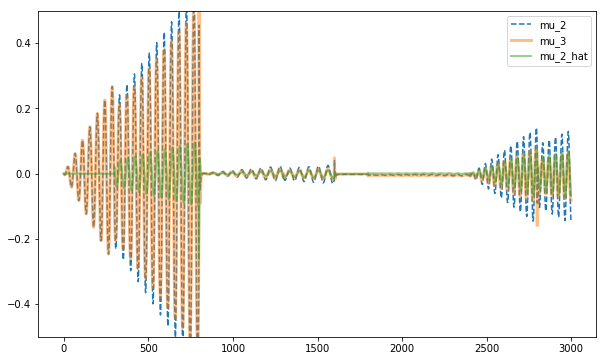

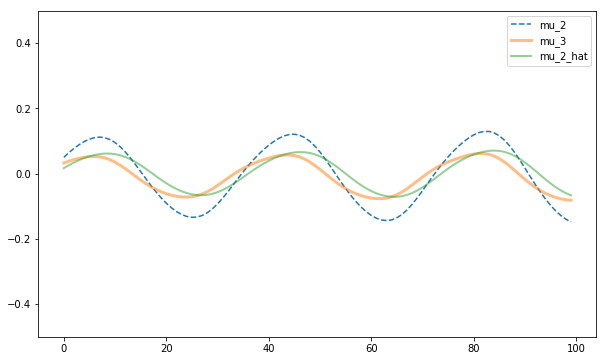

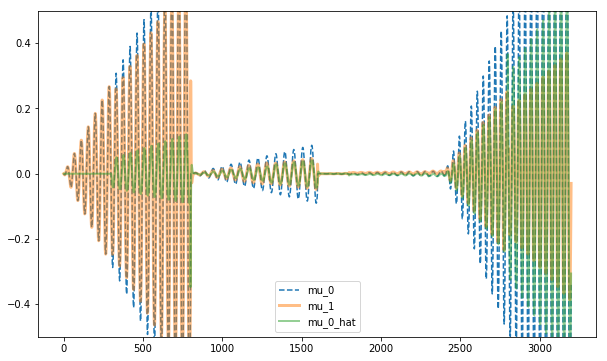

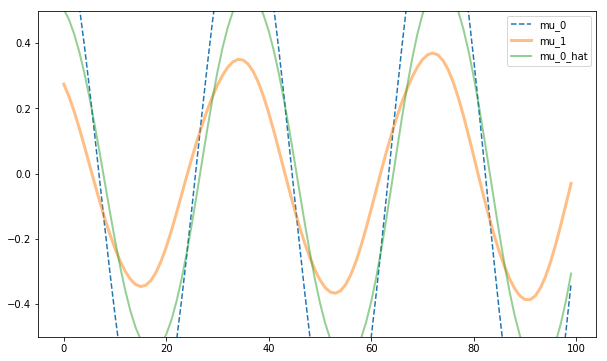

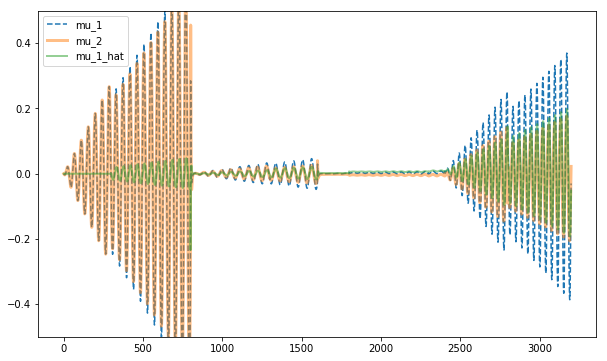

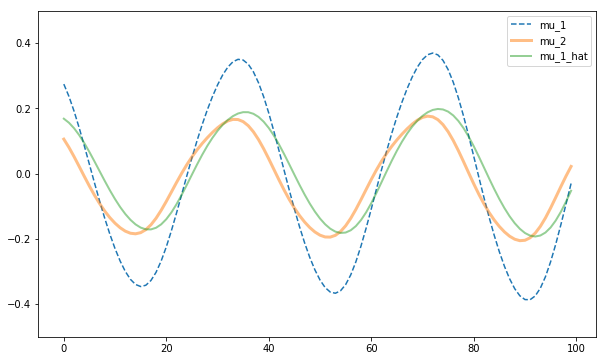

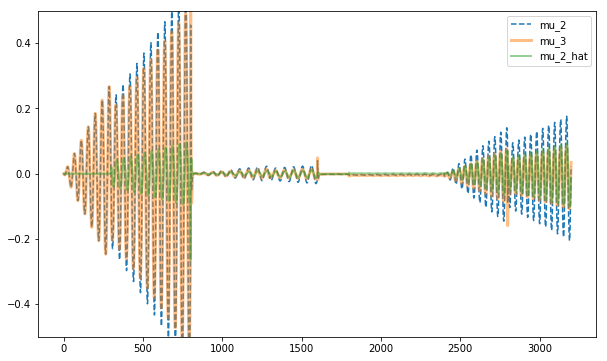

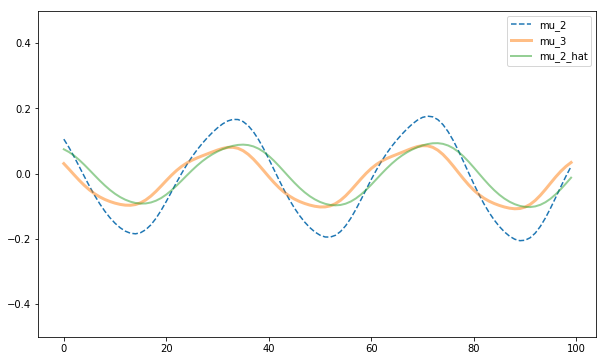

calling fit() with X (500, 300, 1) and y (500, 300, 1)
calling fit() with X (500, 300, 1) and y (500, 300, 1)
calling fit() with X (500, 300, 1) and y (500, 300, 1)


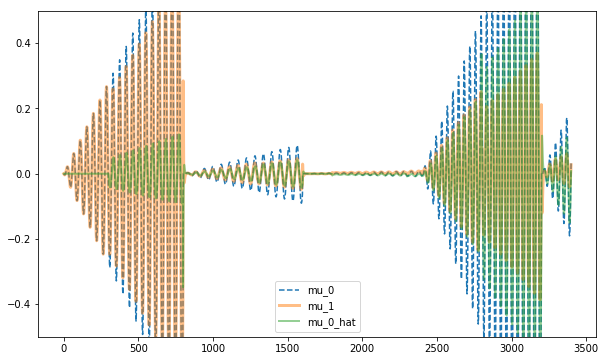

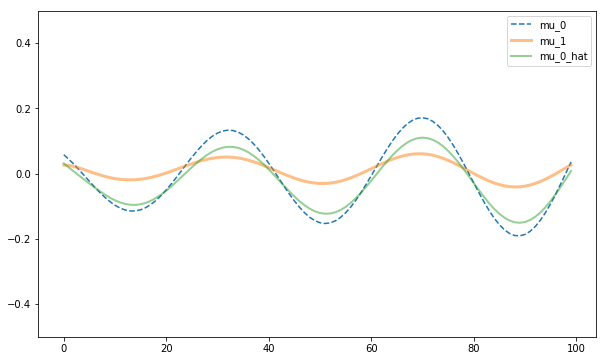

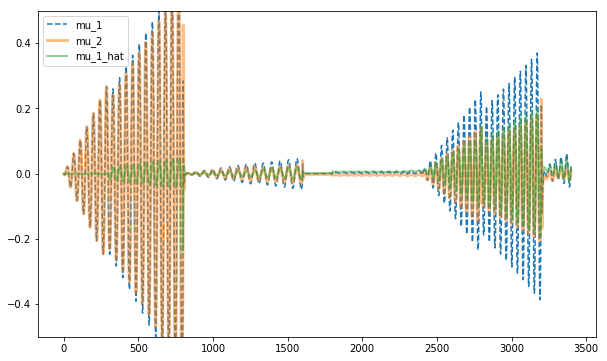

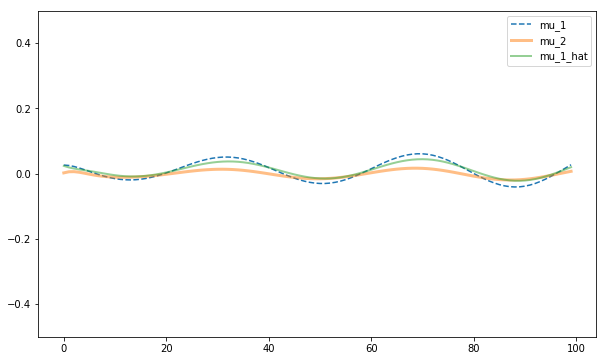

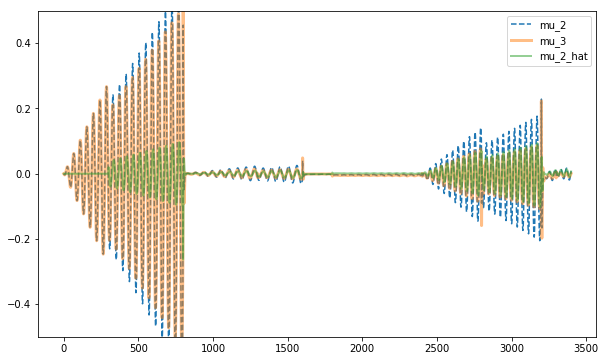

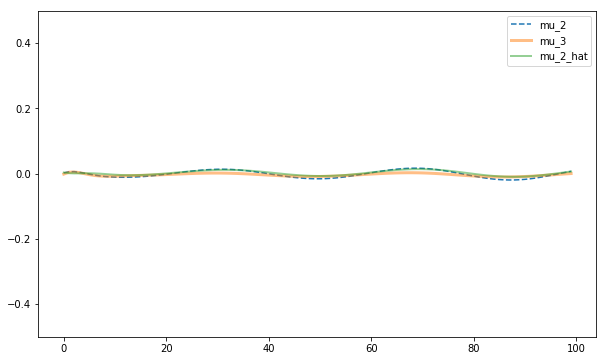

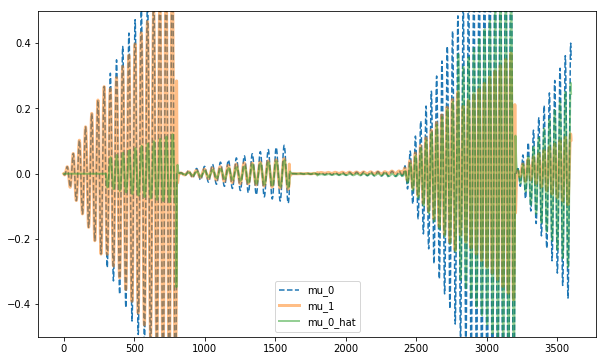

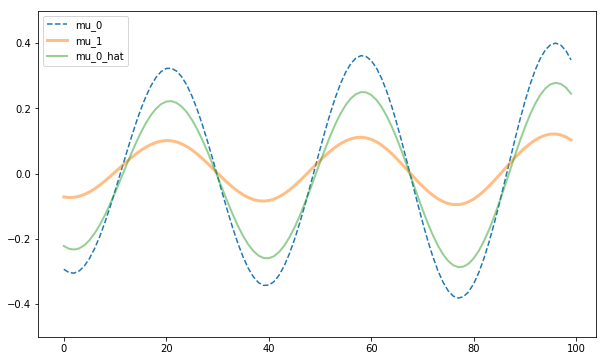

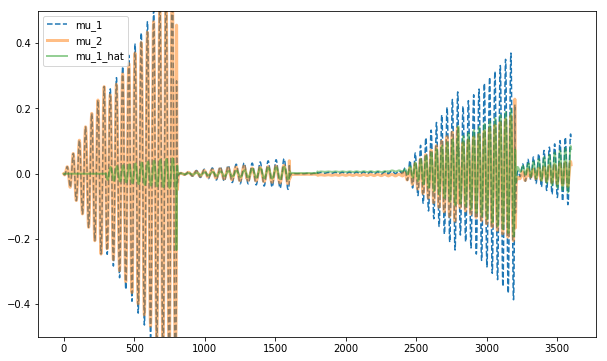

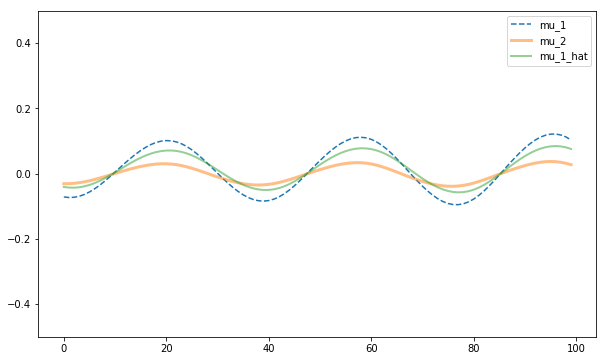

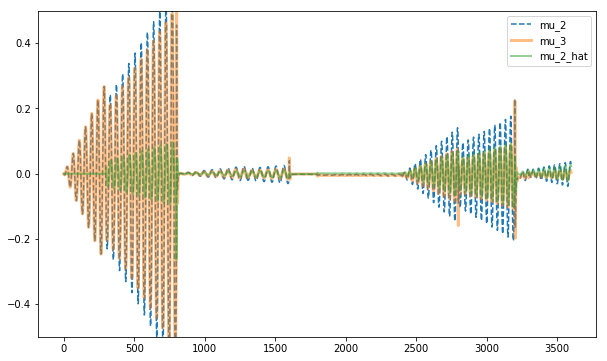

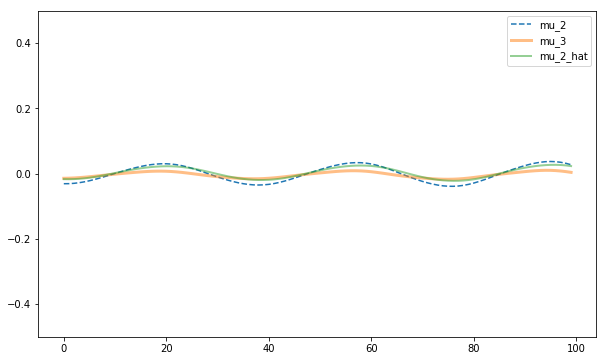

calling fit() with X (500, 300, 1) and y (500, 300, 1)
calling fit() with X (500, 300, 1) and y (500, 300, 1)
calling fit() with X (500, 300, 1) and y (500, 300, 1)


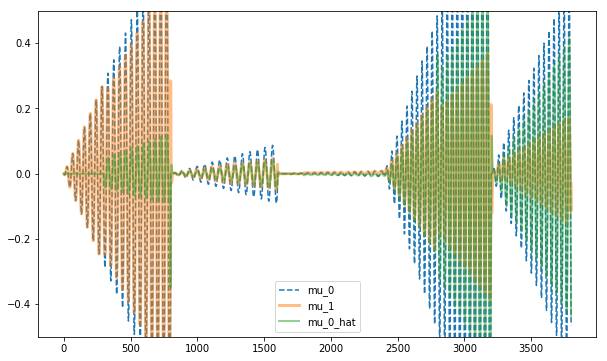

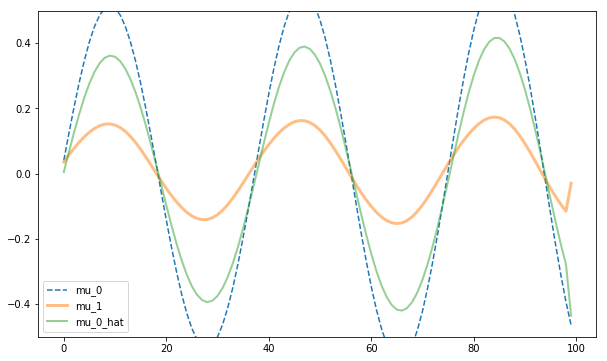

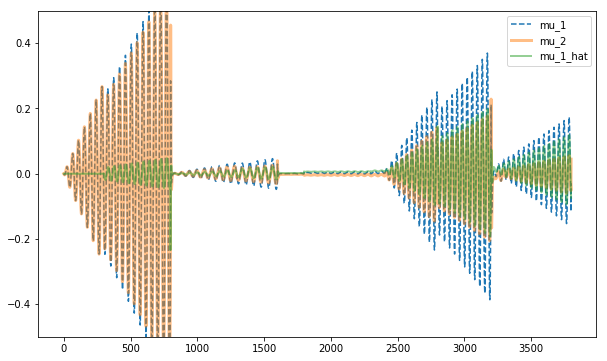

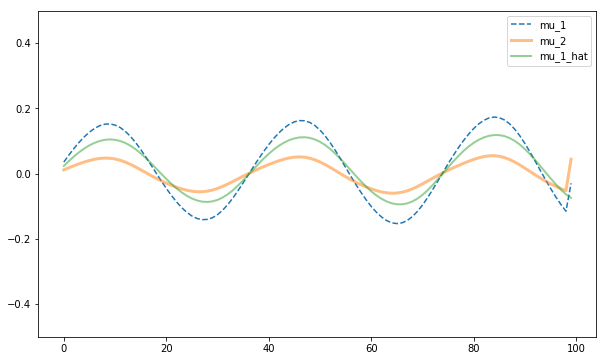

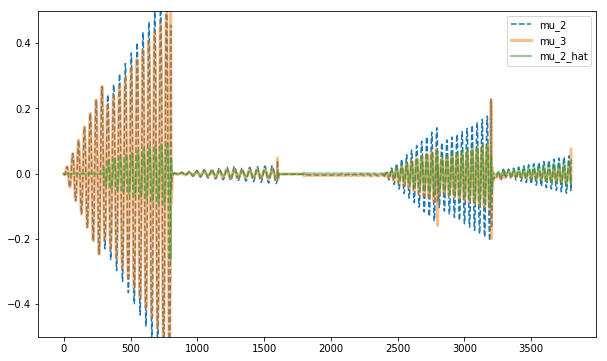

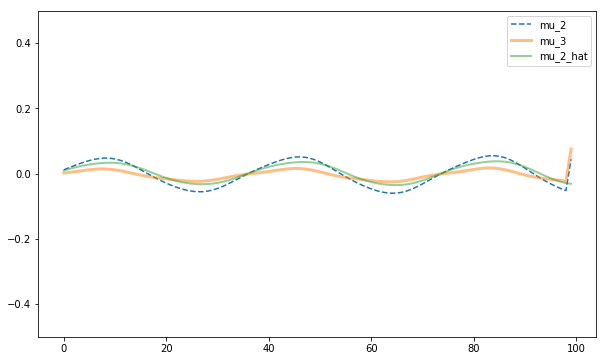

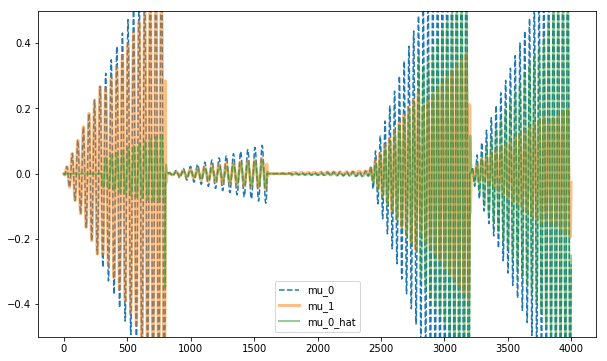

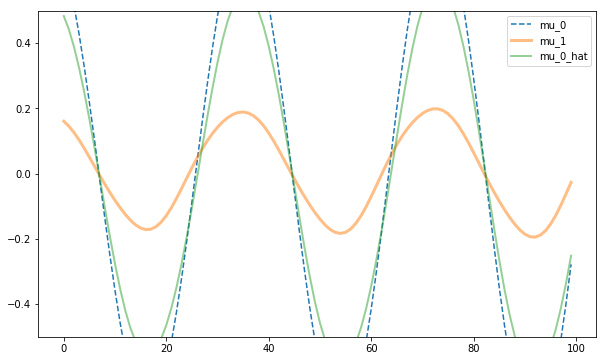

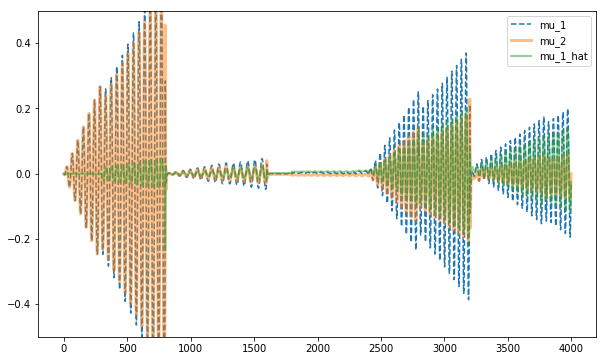

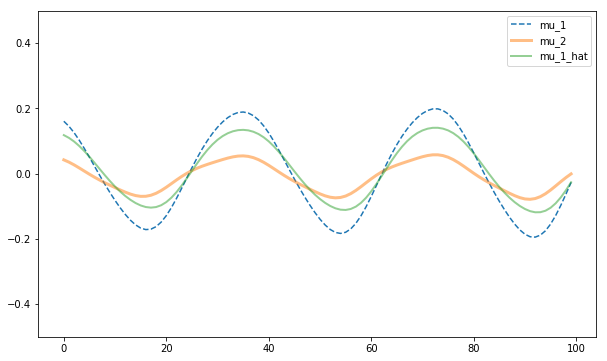

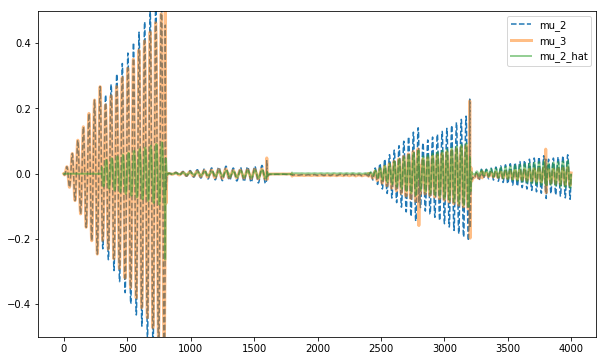

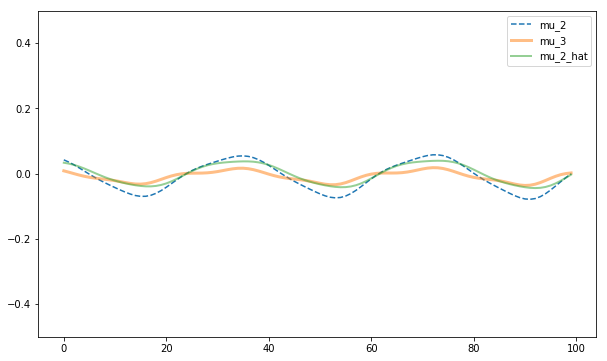

Time Took :9.50 min


In [28]:
from keras import layers

class AmolNetCell(object):
    def __init__(self, cell_index, input_shape, t_sample, n_batch, hidden_neuron_count):
        self.epochs = 20
        self.verbose = False
        self.debug_plots = True

        self.cell_index = cell_index
        self.t_sample = t_sample
        self.n_batch = n_batch
        self.input_shape = input_shape
        self.hidden_neuron_count = hidden_neuron_count

        if self.debug_plots:
            self.plot_mu_0 = []
            self.plot_mu_1 = []
            self.plot_mu_0_hat = []

        self.mu_0 = np.zeros(input_shape)
        self.mu_0_hat = np.zeros(input_shape)

        self.mu_1_sample = None
        self.mu_1_sample_generator = SlidingWindowBuffer(t_sample)

        self.mu_1 = np.zeros(input_shape)
        
        self.create_model()
        
    def create_model(self):
        input_layer = layers.Input(batch_shape=(None, self.t_sample) + self.input_shape, name="input")

        rnn = layers.LSTM(self.hidden_neuron_count,
                        return_sequences=True,
                        name="RNN")(input_layer)

        dense = layers.TimeDistributed(layers.Dense(self.mu_0.size, name="dense"))(rnn)
        self.model = PseudoOnlineModel(inputs=[input_layer], outputs=[dense], n_batch=self.n_batch)

        self.model.compile(loss="mean_squared_error",
                      sample_weight_mode="temporal",
                      optimizer="rmsprop")

        if self.verbose >= 1:
            self.model.summary()

    def downward_step(self, t):
        if self.mu_1_sample is not None:
            self.mu_0_hat = self.model.predict(np.array([self.mu_1_sample]))[0][-1]


    def upward_step(self, t, mu_0):
        self.mu_0 = mu_0

        (history, X_batch, y_batch) = self.model.fit(self.mu_1, self.mu_0, epochs=self.epochs, verbose=self.verbose)

        self.epsilon_0 = self.mu_0 - self.mu_0_hat
        self.mu_1 = self.epsilon_0
        self.mu_1_sample = self.mu_1_sample_generator.append_item(self.mu_1)

        if self.verbose > 2:
            print('---- {0} - Cell {1} ----'.format(t, self.cell_index))
            print('mu_{0} = {1}'.format(self.cell_index, self.mu_0))
            print('mu_{0} = {1}'.format(self.cell_index+1, self.mu_1))
            print('mu_{0}_hat = {1}'.format(self.cell_index, self.mu_0_hat))
            print('epsilon_{0} = {1}'.format(self.cell_index, self.epsilon_0))

        if self.debug_plots:
            self.plot_mu_0.append(self.mu_0)
            self.plot_mu_0_hat.append(np.array(self.mu_0_hat))
            self.plot_mu_1.append(self.mu_1)

            if (t + 1) % 200 == 0:
                plot_samples([
                    {'name': 'mu_{0}'.format(self.cell_index), 'data': np.array(self.plot_mu_0)},
                    {'name': 'mu_{0}'.format(self.cell_index+1), 'data': np.array(self.plot_mu_1)},
                    {'name': 'mu_{0}_hat'.format(self.cell_index), 'data': np.array(self.plot_mu_0_hat)},
                ])
                plot_samples([
                    {'name': 'mu_{0}'.format(self.cell_index), 'data': np.array(self.plot_mu_0[-100:])},
                    {'name': 'mu_{0}'.format(self.cell_index+1), 'data': np.array(self.plot_mu_1[-100:])},
                    {'name': 'mu_{0}_hat'.format(self.cell_index), 'data': np.array(self.plot_mu_0_hat[-100:])},
                ])

        return self.mu_1

t_sample = 300
cells = [
    AmolNetCell(cell_index=0, t_sample=t_sample, n_batch=500, input_shape=(1,), hidden_neuron_count=16),
    AmolNetCell(cell_index=1, t_sample=t_sample, n_batch=500, input_shape=(1,), hidden_neuron_count=16),
    AmolNetCell(cell_index=2, t_sample=t_sample, n_batch=500, input_shape=(1,), hidden_neuron_count=16),
]

start = time.time()

training_points_generator = SampleDataPointsGenerator(800)
for t in range(4000):
    # down steps - flow predictions down
    for cell in reversed(cells):
        cell.downward_step(t)

    # up steps - compare with input and learn
    mu_next = next(training_points_generator)
    for cell in cells:
        mu_next = cell.upward_step(t, mu_next)
    
end = time.time()
print("Time Took :{:3.2f} min".format( (end-start)/60 ))


In [ ]:
for t in range(2000):
    # down steps - flow predictions down
    for cell in reversed(cells):
        cell.downward_step(t)

    # up steps - compare with input and learn
    mu_next = next(training_points_generator)
    for cell in cells:
        mu_next = cell.upward_step(t, mu_next)



## Test the model

In [ ]:
test_points_generator = SampleDataPointsGenerator(int(t_sample * 0.5))

for i in range(3):
    test_sample_X = []
    test_sample_y = []

    # skip some data
    for _ in range(2500):
        next(test_points_generator)

    for _ in range(t_sample):
        X = next(test_points_generator)
        test_sample_X.append(X)

    preds = model.predict([[test_sample_X]])

    if preds is not None:
        plot_samples([
            {'name': 'mu_1', 'data': np.array(test_sample_X)}, 
            {'name': 'mu_0_hat', 'data': preds[0]}
        ])


